# This code will train the model and save weights  using a data generator

First Import libraries

In [42]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

In [43]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [44]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [45]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [46]:
data_path_1 = r"C:\Users\UAB\data\Emory\data\\"
data_path_2 = r"C:\Users\UAB\data\KU\data\\"
data_path_3 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4


print(len(images))



77885


In [47]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


23488
26082
21037
7278


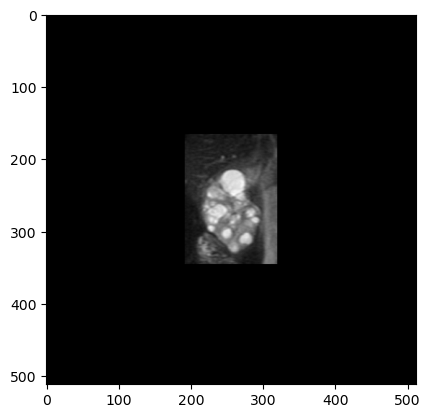

In [48]:
%matplotlib inline

image = np.load(images[-150])
plt.imshow(image, cmap='gray')

In [50]:
#kdata_path_1 = r"D:\EKS-predicted\80-10\\" 
masks_1 = gather_set_and_path(data_path_1, 'ep_K')
masks_2 = gather_set_and_path(data_path_2, 'ep_K')
masks_3 = gather_set_and_path(data_path_3, 'ep_K')
masks_4 = gather_set_and_path(data_path_4, 'ep_K')

masks = masks_1 + masks_2 + masks_3 + masks_4
#masks = gather_set_and_path(kdata_path_1, '_K')
print(len(masks))

77885


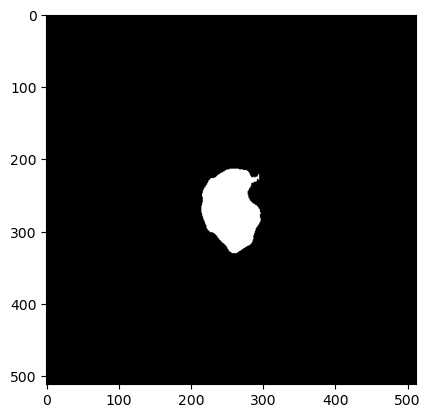

In [51]:
mask = np.load(masks[-150])
plt.imshow(mask, cmap='gray')

In [53]:

labels_1 = gather_set_and_path(data_path_1, '_C')
labels_2 = gather_set_and_path(data_path_2, '_C')
labels_3 = gather_set_and_path(data_path_3, '_C')
labels_4 = gather_set_and_path(data_path_4, '_C')

labels = labels_1 + labels_2 + labels_3 + labels_4

print(len(labels))


78257


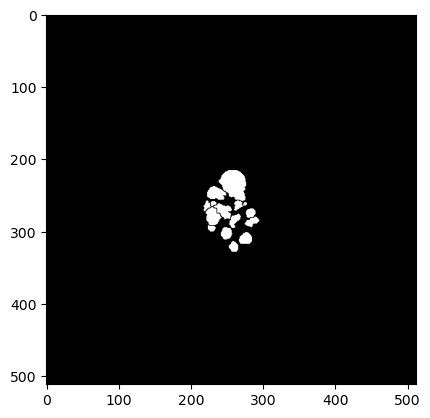

In [54]:
label = np.load(labels[-150])
plt.imshow(label, cmap='gray')

In [55]:
print(masks[-1500])
print(images[-1500])
print(labels[-1500])
test_img = np.load(images[100])
print(test_img.shape, test_img.max(), test_img.min())
test_msk = np.load(masks[100])
print(test_msk.shape, test_msk.max(), test_msk.min())
test_lab = np.load(labels[100])
print(test_lab.shape, test_lab.max(), test_lab.min())


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_ALL_INSTITUTION_80-10_35ep_K.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_C.npy
(512, 512) 129 0
(512, 512) 1 0
(512, 512) 1 0


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [56]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [57]:
print(len(labels))

77885


In [58]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

EM_200922_0


## Image separation for entire patient in training or validation - use with single set of images


In [50]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [51]:
print(len(unique_ids))

350


In [52]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [53]:
print(len(train))
print(len(val))

280
70


In [54]:
print(train[0:2])

['MA_323837_7', 'EM_271043_3']


In [55]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [56]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [57]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [58]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

62241
15644
77885
77885


In [59]:
partition = {'train':train_list, 'validation':val_list}

# Use for given csv file


In [59]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [60]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [61]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [62]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [63]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [64]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [65]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [66]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

In [67]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

41925 L
41925 R
26434 R
26517 L
26517 R
27168 L
27168 R
28393 L
37468 R
37625 L
37625 R
38016 L
17079 L
17079 R
17320 L
17320 R
17875 L
17875 R
18341 L


In [68]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [69]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [70]:
print(len(train_list))
print(len(val_list))

60327
8516


In [71]:
partition = {'train':train_list, 'validation':val_list}

## Use for crossfold validation:

In [27]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [28]:
train_sets = ['MA_', 'KU_', "EM_"]
val_sets = ["UB_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [29]:
print(train_list[100])

C:\Users\UAB\data\Emory\data\\EM_200922_0_144_L_60_M.npy


In [30]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [31]:
print(val_list[100])

C:\Users\UAB\data\UAB\data\\UB_407132_0_95_R_14_M.npy


In [32]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

23488
7278


# Create our data generators 

In [72]:

from Data_Gen_Mask import DataGeneratorK_ALL

In [73]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 2,
          'shuffle': True}
training_generator = DataGeneratorK_ALL(partition['train'], labels, **params)
validation_generator = DataGeneratorK_ALL(partition['validation'], labels, **params)

In [74]:
X, y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 2) (32, 512, 512, 2)


## View output

(512, 512) 93.0 0.0
(512, 512) 1.0 5.193663501775333e-35


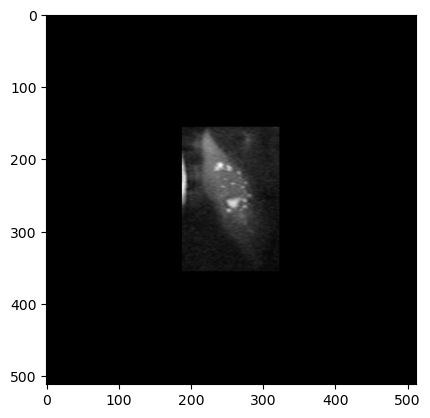

In [75]:
n=4
X_img = X[n,:,:,0]
X_msk =X[n,:,:,1] 
print(X_img.shape, X_img.max(), X_img.min())
print(X_msk.shape, X_msk.max(), X_msk.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

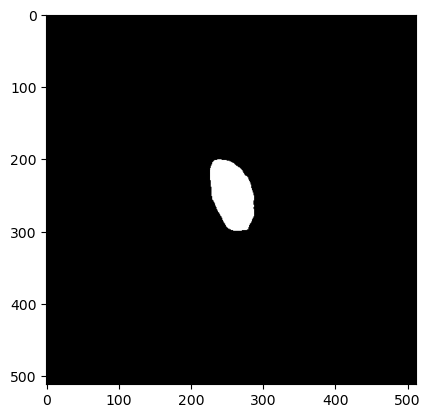

In [76]:
%matplotlib inline
plt.imshow(X_msk, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

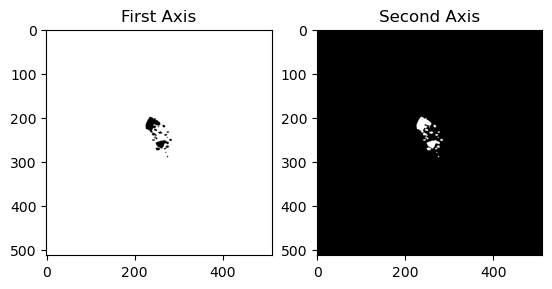

In [77]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [78]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#model.summary()

In [79]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [87]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
model_name = "cyst_seg_80-10_kidney_split_10epoch.h5"
filepath = model_name
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [88]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [89]:
# Train model on dataset
history = model.fit(training_generator, epochs = 10,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/10
1885/1885 [==============================] - 4155s 2s/step - loss: 0.0072 - dice_coef: 0.9963 - val_loss: 0.0031 - val_dice_coef: 0.9984
Epoch 2/10
1885/1885 [==============================] - 4224s 2s/step - loss: 0.0026 - dice_coef: 0.9987 - val_loss: 0.0026 - val_dice_coef: 0.9987
Epoch 3/10
1885/1885 [==============================] - 4199s 2s/step - loss: 0.0022 - dice_coef: 0.9989 - val_loss: 0.0023 - val_dice_coef: 0.9988
Epoch 4/10
1885/1885 [==============================] - 4191s 2s/step - loss: 0.0019 - dice_coef: 0.9990 - val_loss: 0.0022 - val_dice_coef: 0.9989
Epoch 5/10
1885/1885 [==============================] - 4247s 2s/step - loss: 0.0018 - dice_coef: 0.9991 - val_loss: 0.0022 - val_dice_coef: 0.9989
Epoch 6/10
1885/1885 [==============================] - 4311s 2s/step - loss: 0.0017 - dice_coef: 0.9991 - val_loss: 0.0023 - val_dice_coef: 0.9988
Epoch 7/10
1885/1885 [==============================] - 4361s 2s/step - loss: 0.0016 - dice_coef: 0.9992 - val_l

In [90]:
from keras.models import Sequential, load_model
model.save(model_name)    

In [91]:
print(cb.logs)
print(sum(cb.logs))

[4154.6395328, 4223.7884553, 4199.334582599997, 4191.150456299998, 4247.3542333000005, 4310.740140299997, 4360.766564400001, 4291.958325500003, 4246.068701000004, 4336.769740000003]
42562.5707315


In [92]:
sum(cb.logs)/3600

11.822936314305556

In [97]:
time = list(cb.logs)
print(time)

[4154.6395328, 4223.7884553, 4199.334582599997, 4191.150456299998, 4247.3542333000005, 4310.740140299997, 4360.766564400001, 4291.958325500003, 4246.068701000004, 4336.769740000003]


In [98]:
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

In [99]:
df['epoch_time'] = np.array(cb.logs)

In [100]:
df.to_csv('cyst_seg_80-10_split_10epoch_corrected.csv')

In [101]:
import pandas as pd

DF = pd.read_csv('cyst_seg_80-10_split_10epoch_corrected.csv')

print(DF) 

   Unnamed: 0      loss  dice_coef  val_loss  val_dice_coef   epoch_time
0           0  0.007210   0.996340  0.003129       0.998404  4154.639533
1           1  0.002634   0.998659  0.002642       0.998656  4223.788455
2           2  0.002152   0.998902  0.002333       0.998815  4199.334583
3           3  0.001924   0.999020  0.002151       0.998901  4191.150456
4           4  0.001789   0.999086  0.002163       0.998897  4247.354233
5           5  0.001698   0.999133  0.002295       0.998829  4310.740140
6           6  0.001601   0.999184  0.002091       0.998933  4360.766564
7           7  0.001553   0.999208  0.002402       0.998775  4291.958326
8           8  0.001493   0.999238  0.002306       0.998824  4246.068701
9           9  0.001445   0.999263  0.002183       0.998886  4336.769740


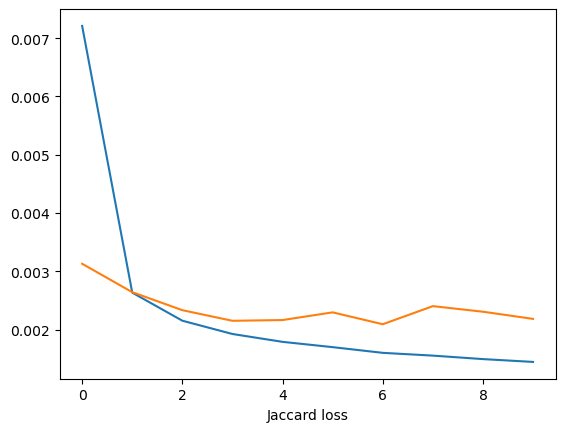

In [102]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

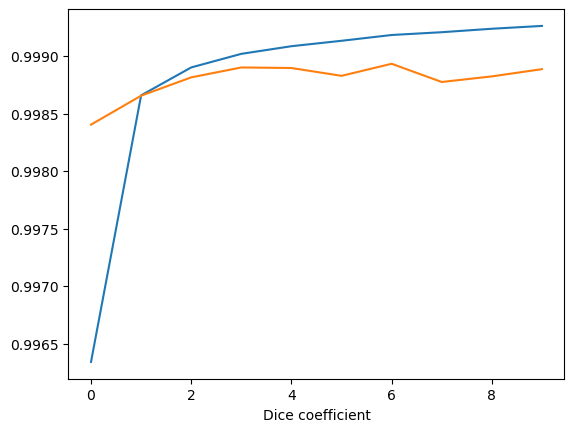

In [103]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')